In [1]:
import numpy as np
import pandas as pd
import math
from scipy.spatial.distance import euclidean, cityblock, correlation, chebyshev, cosine

import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

In [2]:
df = pd.read_csv('non-parametric.csv', delimiter = ';')
X = df.iloc[:, :-1] 
Y = df.iloc[:, -1]

x_array = X['x'].tolist()
y_array = Y.tolist()

df.head()

,id,x,y
0,1,2.4,0.0
1,2,2.6,-1.3
2,3,3.2,-2.7
3,4,3.6,0.0
4,5,4.0,-2.7


In [3]:
# kernels
square_kernel = lambda u: 15.0 / 16 * (1 - u ** 2) ** 2 * (abs(u) <= 1)
epan_kernel = lambda u: 0.75 * (1 - u ** 2) * (abs(u) <= 1)
gauss_kernel = lambda u: (2 * math.pi) ** (-1.0 / 2)* math.exp(-u ** 2 / 2.0)
triangle_kernel = lambda u: (1 - abs(u)) * (abs(u) <= 1)
rectangle_kernel = lambda u: 1.0 / 2 * (abs(u) <= 1)


kernels = [square_kernel, epan_kernel, gauss_kernel, rectangle_kernel]
kernelNames= ['square', 'epan', 'gauss', 'rectangle']

In [4]:
class KernelRegressor:
    
    my_X = []
    my_Y = []
    window = None
    kernel = gauss_kernel
    metric = euclidean
    
#     todo lowess
    
    def NadarayaWatson(self, x):
        l = len(self.my_Y)
        num = 0
        denom = 0
        for i in range(l):
            dist = abs(x - self.my_X[i])
            k = self.kernel(dist/self.window)
            num += self.my_Y[i] * k
            denom += k
        if (denom == 0):
            return 0
        return num/denom

    def NadarayaWatsonExceptSelf(self, self_ind):
        l = len(self.my_Y)
        num = 0
        denom = 0
        for i in range(l):
            if (i != self_ind):
                dist = abs(self.my_X[self_ind] - self.my_X[i])
                k = self.kernel(dist/self.window)
                num += Y[i] * k
                denom += k
        if (denom == 0):
            return 0
        return num/denom
    
    def crossValidationWithNW(self):
        cv = 0
        n = len(self.my_Y)
        for i in range(n):
            cv += (self.my_Y[i] - self.NadarayaWatsonExceptSelf(i)) ** 2
        cv /= n
        return cv
    
    def fit(self, X, Y, window = None, kernel = gauss_kernel, metric = euclidean):
        self.my_X = X
        self.my_Y = Y
        self.kernel = kernel
        self.metric = metric
        self.window = window
        
        if (window is None):
            self.window = 0.1
            best_window = self.window
            minMSE = self.crossValidationWithNW()
            window_variety = np.linspace(0.1, 5, 10)
            for w in window_variety:
                self.window = w
                mse = self.crossValidationWithNW()
                if (mse < minMSE):
                    print('mse', mse, 'prev', minMSE)
                    best_window = w
                    minMSE = mse
            self.window = best_window
            print('Chosen best window as ', best_window)
        
    def predict(self, X_test):
        Y_hat = []
        for i in range(len(X_test)):
            Y_hat.append(self.NadarayaWatson(x = X_test[i]))
        return Y_hat

In [5]:
class SplineRegressor:
    
    def g(self, j, x):
        if j <= self.k:
            return x**j
        else:
            return max(0, (x - self.t[j - self.k - 1])**(self.k))
    
    def init_params(self, X, Y, knots=10, power=3):
        self.X = X
        self.Y = Y
        
        self.n = len(X)
        self.k = power
        self.m = knots
        self.t = []
        
        step = self.n // self.m
        cur = 0
        for i in range(0, self.m):
            self.t.append(X[cur])
            if i == knots - 2:
                cur = self.n - 1
            else:
                cur += step
    
    def f_hat(self, x):
        res = 0
        for j in range(0, self.m + self.k + 1):
            res += self.beta_hat[j] * self.g(j, x)
        return res
    
    def fit(self, X, Y, knots=10, power=3):
        self.init_params(X, Y, knots, power)
        
        self.G = np.zeros((self.n, self.m + self.k + 1))
        for i in range(0, self.n):
            for j in range(0, self.m + self.k + 1):
                self.G[i][j] = self.g(j, self.X[i])
        
        self.beta_hat = np.linalg.pinv(np.dot(self.G.T, self.G)).dot(self.G.T).dot(np.array(self.Y))
        
    def predict(self, X_test):
        Y_hat = []
        for i in range(len(X_test)):
            Y_hat.append(self.f_hat(X_test[i]))
        return np.array(Y_hat)

In [6]:
def showKernelLine(ax, kernel = square_kernel, kernel_name = 'square'):
    regressor = KernelRegressor()
    regressor.fit(x_array, y_array, kernel = kernel, window=2.)
    test_x = list(np.arange(0, 60, 0.5))
    pred_y = regressor.predict(test_x)

    ax.plot(test_x, pred_y, label = kernel_name)
    
def kernelPlotDrawer(ax):
    for i in range(len(kernels)):
        showKernelLine(ax, kernels[i], kernelNames[i])

In [7]:
def splinePlotDrawer(ax):
    regressor = SplineRegressor()
    for i in range(3, 7):
        regressor.fit(x_array, y_array, knots=10, power=i)
        ax.plot(x_array, regressor.predict(x_array), label = 'power = {}'.format(i))

In [8]:
def drawGraphs(plotsDrawer, title):
    mpl.style.use('default')
    plt.clf()
    fig, ax = plt.subplots(figsize=(11, 8))

    plt.title(title)
    plt.ylabel('y')
    plt.xlabel('x')

    plt.plot(x_array, y_array, 'o', markersize=1)

    plt.rc('lines', linewidth=1)
    ax.set_prop_cycle(cycler('color', ['#258039', '#CF3721', '#F5BE41', '#31A9B8']))
    plotsDrawer(ax)
    
    plt.legend(loc='best')
    plt.show() 

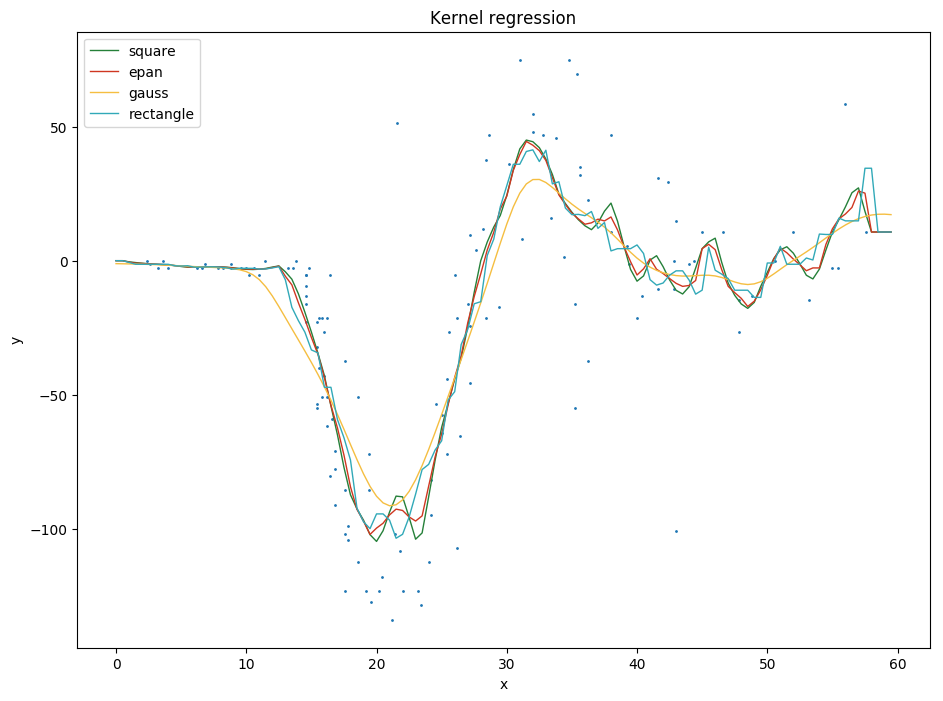

In [9]:
drawGraphs(kernelPlotDrawer, "Kernel regression")

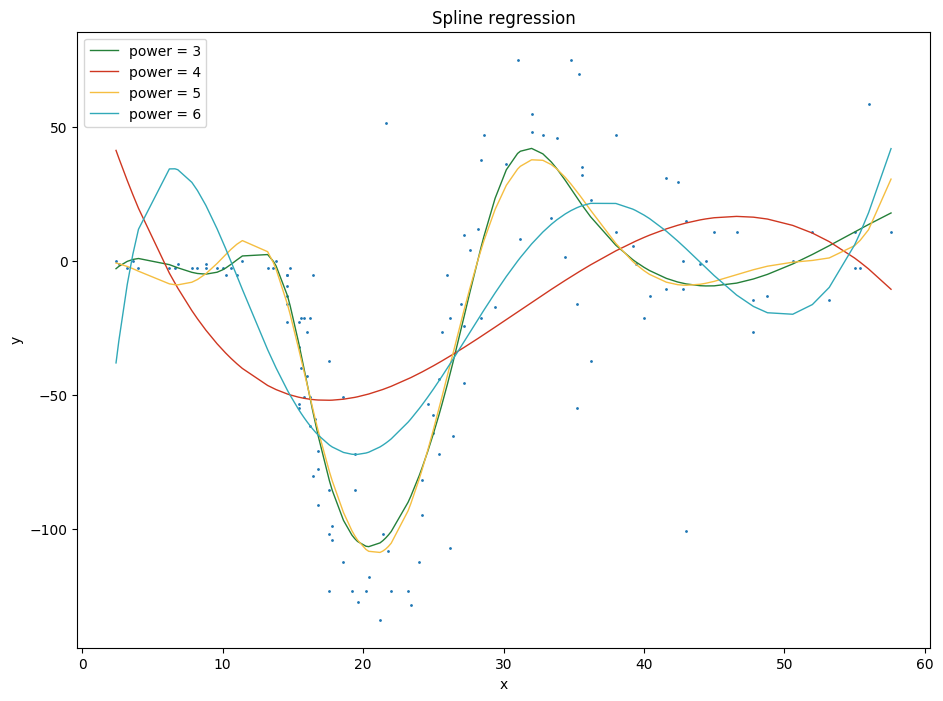

In [10]:
drawGraphs(splinePlotDrawer, "Spline regression")

mse 959.758660746 prev 959.779388776
Chosen best window as  3.0202020202

mse 950.992430583 prev 951.480191423
Chosen best window as  1.58484848485

mse 954.429077658 prev 954.473091939
Chosen best window as  1.13939393939

mse 959.627599077 prev 959.656597565
Chosen best window as  3.0696969697

mse 916.320592301 prev 919.768189628
Chosen best window as  1.23838383838

In [11]:
def fitSpline(knots=10, power=3):
    return lambda regressor, X, Y: regressor.fit(X, Y, knots=knots, power=power)

def fitKernel(window):
    return lambda regressor, X, Y: regressor.fit(X, Y, kernel = gauss_kernel, window = window)

def crossValidationScore(X, Y, regressor, fitFunc):
    err = 0
    for c in range(len(X)):
        X_train = np.delete(X, c, 0)
        Y_train = np.delete(Y, c, 0)
        fitFunc(regressor, X_train, Y_train)
        Y_hat = regressor.predict([X[c]])
        err += (Y_hat[0] - Y[c])**2
    return math.sqrt(err / len(X))

In [12]:
crossValidationScore(x_array, y_array, SplineRegressor(), fitSpline(9, 3))

29.133125156071472

In [13]:
crossValidationScore(x_array, y_array, KernelRegressor(), fitKernel(window=1.23))

30.909863056798628